In [159]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne_nirs.statistics import statsmodels_to_results

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mne_nirs.statistics import run_glm
import matplotlib as mpl
from mne.stats import fdr_correction


# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [160]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 50

# Time from trigger point being evaluated
tmin = -1
tmax = 50

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False





In [161]:
# # FV Study Parameters
# ignore = [".DS_Store", ".git", "sub-18", "sub-14", ".gitignore"]
# columns_for_group_analysis = ['Neutral', 'Concern']
# columns_for_glm_contrast = ['Neutral', 'Concern']
# path = '../../FV_Prelim_Data/'
# trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}
# columns_for_fdr = ['Neutral', 'Concern']

In [162]:
# # FA Study Parameters
# columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']
# columns_for_glm_contrast = ['Neutral', 'Inflam', 'Control']
# columns_for_fdr = ['Control', 'Inflam']
# path = "../../LabResearch/IndependentStudy/Data/FA"
# ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}

In [163]:
# Oculus Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/oculus_montage_bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [164]:
# N-Back Control Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/n-back-bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [165]:
# Live Drive
ignore = [".DS_Store", ".git", "sub-01", ".gitignore"]
columns_for_group_analysis = ['Driving']
columns_for_glm_contrast = ['Driving']
path = '../../LiveDrive'
trigger_id = {'2': 'Driving'}
columns_for_fdr = ['Driving']

In [166]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time, tmin=tmin, tmax=tmax)
        
        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        
        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        raw_haemo = all_data[0]['raw_haemo']
        
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [167]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        
        raw_haemo = all_data[0]['raw_haemo']

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [168]:
importlib.reload(glm_analysis)
group_data, all_epochs, all_evokeds, glm_results = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=tmin, tmax=tmax, trigger_id=trigger_id)

print(glm_results)


Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../../Desktop/oculus_montage_bids/oculus/sub-1/nirs/2023-03-22_002.snirf
Reading 0 ... 4734  =      0.000 ...   407.124 secs...
{'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}
[[ 17   0   1]
 [ 65   0   1]
 [126   0   3]
 [172   0   3]
 [219   0   2]
 [265   0   2]] {'oneBack': 1, 'threeBack': 2, 'twoBack': 3}
sub_id 1
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../../Desktop/oculus_montage_bids/oculus/sub-2/nirs/2023-03-22_003.snirf
Reading 0 ... 4741  =      0.000 ...   407.726 secs...
{'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}
[[ 17   0   1]
 [ 67   0   1]
 [121   0   3]
 [171   0   3]
 [221   0   2]
 [272   0   2]] {'oneBack': 1, 'threeBack': 2, 'twoBack': 3}
sub_id 2
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../../Desktop/oculus_montage_bids/oculus/sub-4/nirs/2023-03-24_002.snirf
Reading 0 ... 6779  =      0.000 ...   582.994 secs...
{'1': 'oneBack', '2': 'twoBack',

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return all_sig_channels
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return all_sig_channels


In [169]:
# individual_data, all_epochs, all_evokeds = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, trigger_id)
# individual_data

# Visualizations

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[vals] = model_data[vals].astype(float)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

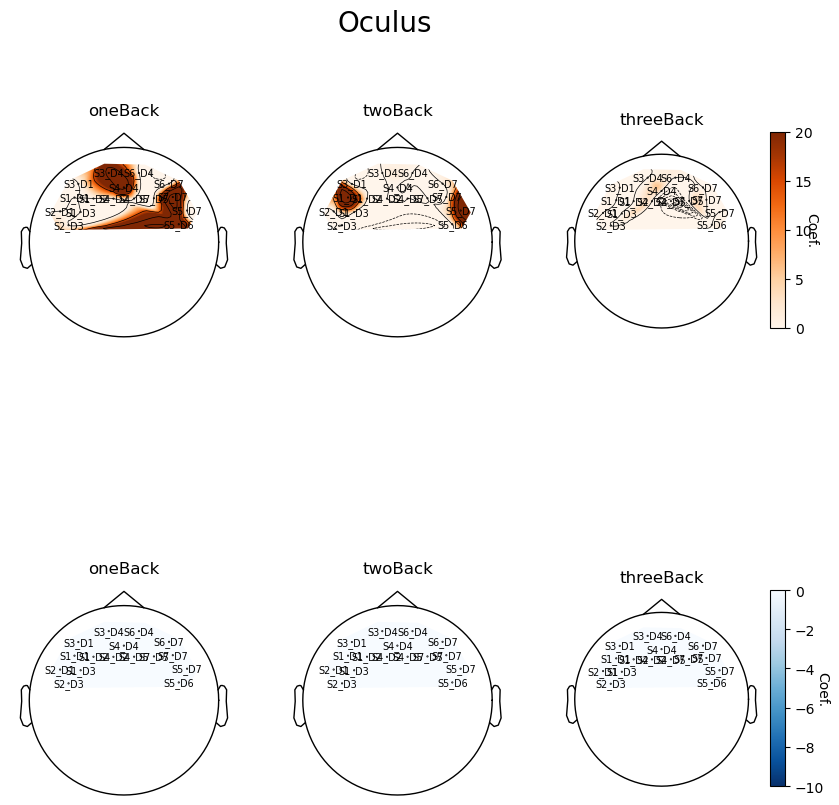

In [170]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()
    raw_haemo = all_data[0]['raw_haemo']
    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo, group)

In [171]:
# Group Visualization with FDR Correction
importlib.reload(visualizations)
importlib.reload(analysis_tools)
ignored_vals = ['drift', 'Start', 'constant']

groups = list(group_data.keys())
results = {}
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

    channels_df_fdr = analysis_tools.false_discovery_rate_correction(channels_df, ignored_vals, columns_for_fdr)

    raw_haemo = all_data[0]['raw_haemo']

    alpha = 0.05
    p_vals = channels_df['p_value']
    reject_fdr, pval_fdr = fdr_correction(p_vals, alpha=alpha, method='indep')
    channels_df['fdr_status'] = reject_fdr
    channels_df_fdr = channels_df.loc[(channels_df['fdr_status'] == True) & (~channels_df['Condition'].isin(ignored_vals))]
    channels_df_fdr = channels_df_fdr.drop_duplicates()
    print(channels_df)
    
    # channels_df_fdr.to_csv('channels_df_fdr.csv')
    # visualizations.group_topological_visualisation(channels_df_fdr, columns_for_glm_contrast, raw_haemo, group)

variable  Condition    df           mse   p_value            se         t  \
0          constant  12.0  3.164394e-12  0.023158  1.042789e-06 -2.601594   
1           drift_1  12.0  3.164394e-12  0.566206  1.771920e-05 -0.589891   
2           drift_2  12.0  3.164394e-12  0.306118  1.704146e-05  1.068962   
3           drift_3  12.0  3.164394e-12  0.935947  1.482705e-05  0.082066   
4           drift_4  12.0  3.164394e-12  0.758511  1.618449e-05 -0.314542   
...             ...   ...           ...       ...           ...       ...   
5827        drift_8  15.0  8.215165e-13  0.876857  5.232850e-06 -0.157622   
5828        drift_9  15.0  8.215165e-13  0.562724  5.293741e-06 -0.591915   
5829        oneBack  15.0  8.215165e-13  0.765815  6.799321e-07 -0.303317   
5830      threeBack  15.0  8.215165e-13  0.035872  7.491552e-07  2.305054   
5831        twoBack  15.0  8.215165e-13  0.829097  6.943468e-07  0.219661   

variable         theta Source Detector Chroma  Significant    ch_name  ID  

In [172]:
# # Group Cortical Projections
# importlib.reload(visualizations)
# groups = list(group_data.keys())
# for group in groups:
#     # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
#     channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

#     raw_haemo = all_data[0]['raw_haemo']
#     visualizations.group_cortical_surface_projection(channels_df, columns_for_glm_contrast, raw_haemo, path)

[<Evoked | 'oneBack' (average, N=2), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'oneBack' (average, N=2), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'oneBack' (average, N=2), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'oneBack' (average, N=2), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>]
combining channels using "mean"
[<Evoked | 'threeBack' (average, N=2), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'threeBack' (average, N=2), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'threeBack' (average, N=2), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'threeBack' (average, N=2), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>]
combining channels using "mean"
[<Evoked | 'twoBack' (average, N=2), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 kB>, <Evoked | 'twoBack' (average, N=2), -1.25 – 50 sec, baseline -1.25 – 0 sec, 36 ch, ~171 

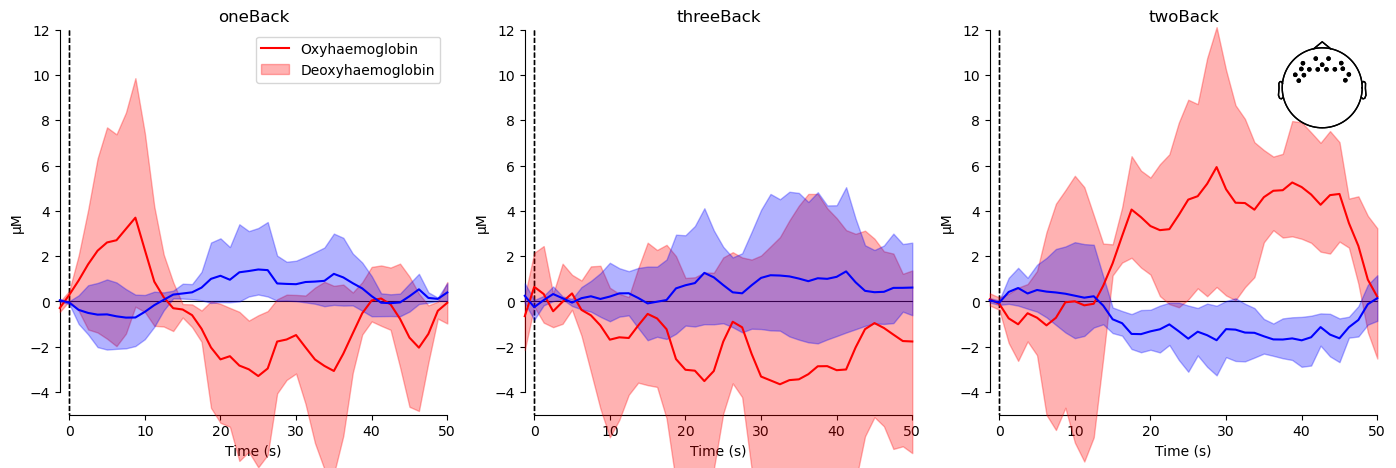

In [173]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, interval_length, variable_epoch_time)

In [174]:
# Individual Visualization
# importlib.reload(visualizations)
# if individual_data:
#     channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

#     raw_haemo = all_data[0]['raw_haemo']

#     visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

# Export Results

In [175]:
# Download the Results
keys = list(group_data.keys())
complete_results = pd.DataFrame()
for key in keys:
    sig_cha = group_data[key]['significant_channels']
    print(sig_cha)
    sig_cha['group'] = key
    complete_results = pd.concat([complete_results, sig_cha])
    complete_results['Coef.'] = complete_results['Coef.'] * 1e6
# complete_results.to_csv('liveDrive.csv')

                        Coef.  Std.Err.          z         P>|z|    [0.025  \
ch_name   Condition                                                          
S1_D1 hbo twoBack    0.000004  0.000002   2.250209  2.443570e-02       0.0   
S3_D4 hbo oneBack    0.000003  0.000002   2.081392  3.739804e-02       0.0   
S4_D4 hbo oneBack    0.000003  0.000002   2.111045  3.476843e-02       0.0   
S4_D5 hbo threeBack -0.000004  0.000002  -2.443678  1.453838e-02 -0.000007   
S4_D8 hbo oneBack   -0.000005  0.000002  -2.894935  3.792367e-03 -0.000008   
          threeBack -0.000015  0.000002  -9.620125  6.575104e-22 -0.000018   
          twoBack   -0.000015  0.000002  -9.691665  3.271525e-22 -0.000018   
S5_D6 hbo oneBack    0.000004  0.000002   2.291009  2.196287e-02  0.000001   
S5_D7 hbo twoBack    0.000003  0.000002   2.170357  2.997984e-02       0.0   
S7_D6 hbo threeBack -0.000004  0.000002  -2.666238  7.670537e-03 -0.000007   
S7_D7 hbo oneBack    0.000005  0.000002   3.244625  1.176054e-03